In [4]:
# coding=utf-8
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import sys, os, math, time
from scipy.signal import butter, lfilter
from scipy import signal


sys.path.append('/disk1/home/wangrj/LDC/MLDC-master/software/LDCpipeline/scripts')

#sys.path.append(os.path.abspath('../../../../../LDC/software/Waveforms/MBH_IMR/MP/'))
#sys.path.append(os.path.abspath('../../../../../LDC/software/Packages/common/'))
#sys.path.append(os.path.abspath('../../../../../LDC/software/MLDCpipeline/scripts/'))
from pycbc.psd.read import from_numpy_arrays
from pycbc import noise,frame
from pyIMRPhenomD import IMRPhenomD, MSUN_SI, PC_SI
import Cosmology
import LISAConstants as LC
#import ParseWriteXML as pwXML
from LISAhdf5 import LISAhdf5,ParsUnits
from pyFDresponse import *
from psd import parse_arguments,Series
from tdi import *
from LISACommonFunctions import *
from GenerateFD_SignalTDIs import *


generate noise  with pycbc

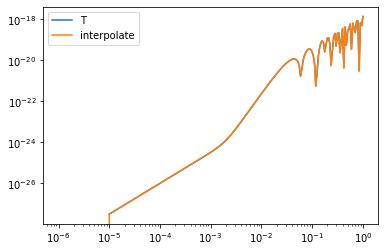

In [6]:
df= 1.0/10**6
flen= int(1.0/df)+1
flow=1e-5
freq_data= logsampling(1e-5,1.0,200)
PSD_TDIT= noisepsd_T(freq_data)

psdT = from_numpy_arrays(freq_data, PSD_TDIT, flen, df,flow)
plt.loglog(freq_data,np.sqrt(PSD_TDIT*freq_data),label='T')
plt.loglog(psdT.sample_frequencies,np.sqrt(psdT*psdT.sample_frequencies),label='interpolate')
plt.legend()

250001 1000001


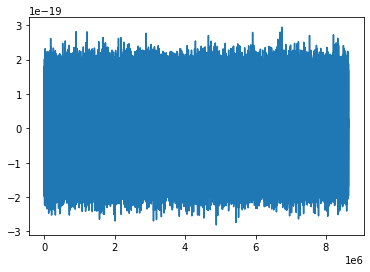

In [7]:
### Generate 1 year of noise 
Tobs=3600*24*100
del_t= 2
tsamples = int(Tobs / del_t)
noiseT = noise.noise_from_psd(tsamples, del_t, psdT)
plt.plot(noiseT.sample_times, noiseT)

Computing PSD for T (using 4320000 points at 0.5 Hz)...


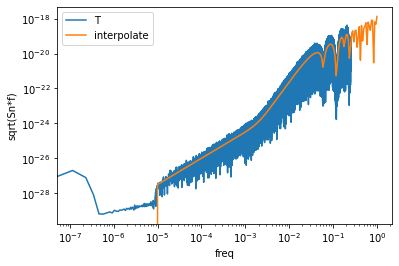

In [8]:
noise_T =Series(noiseT.sample_times,noiseT,'T')
psdT_estimated= noise_T.compute(nperseg=None, overlap=0.5, window='nuttall')
#psdt,f=plt.psd(ts,NFFT=2**14,Fs=1/5)
plt.loglog(psdT_estimated.frequencies,np.sqrt(psdT_estimated.frequencies*psdT_estimated.psd),label=psdT_estimated.title)
plt.loglog(psdT.sample_frequencies,np.sqrt(psdT*psdT.sample_frequencies),label='interpolate')
#plt.loglog(f,np.sqrt(psdt*f),label='plt.psd')
plt.ylabel('sqrt(Sn*f)')
plt.xlabel('freq')
plt.legend()

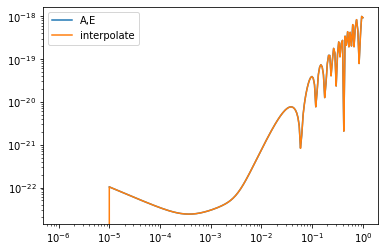

250001 1000001


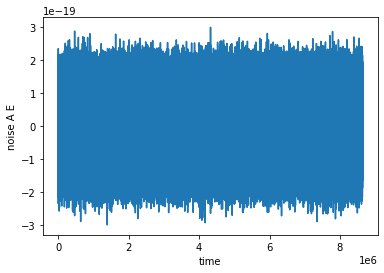

Computing PSD for A (using 4320000 points at 0.5 Hz)...


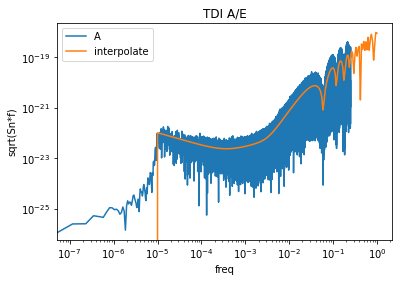

In [12]:
PSD_TDIAE= noisepsd_AE(freq_data)

psdAE = from_numpy_arrays(freq_data, PSD_TDIAE, flen, df,flow)
plt.loglog(freq_data,np.sqrt(PSD_TDIAE*freq_data),label='A,E')
plt.loglog(psdAE.sample_frequencies,np.sqrt(psdAE*psdAE.sample_frequencies),label='interpolate')
plt.legend()
plt.show()
########################
noiseAE = noise.noise_from_psd(tsamples, del_t, psdAE)
plt.plot(noiseAE.sample_times, noiseAE)
plt.xlabel('time')
plt.ylabel('noise A E')
plt.show()
#####################
noise_AE =Series(noiseAE.sample_times,noiseAE,'A')
psdAE_estimated= noise_AE.compute(nperseg=None, overlap=0.5, window='nuttall')
#psdt,f=plt.psd(ts,NFFT=2**14,Fs=1/5)
plt.loglog(psdAE_estimated.frequencies,np.sqrt(psdAE_estimated.frequencies*psdAE_estimated.psd),label=psdAE_estimated.title)
plt.loglog(psdAE.sample_frequencies,np.sqrt(psdAE*psdAE.sample_frequencies),label='interpolate')
#plt.loglog(f,np.sqrt(psdt*f),label='plt.psd')
plt.ylabel('sqrt(Sn*f)')
plt.xlabel('freq')
plt.title('TDI A/E')
plt.legend()
